In [1]:
import random
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from imblearn.over_sampling import SMOTE

from pyts.image import GramianAngularField

In [2]:
class ArrhythmiaLabels:
    labels = {
        0: "N",
        1: "S",
        2: "V",
        3: "F",
        4: "Q",
    }
    size = 5

def visualize_raw_ecg(data: dict[str, pd.DataFrame]) -> None:
    features = data["features"]
    labels   = data["labels"]

    example_idx = []
    for label in range(ArrhythmiaLabels.size):
        indices = labels[labels == label].index
        index   = random.choice(indices)
        example_idx.append(index)

    example_features = features.iloc[example_idx]

    _, ax = plt.subplots(1, ArrhythmiaLabels.size, figsize=(20, 5))
    for i in range(ArrhythmiaLabels.size):
        ax[i].plot(example_features.iloc[i])
        ax[i].set_title(f"{ArrhythmiaLabels.labels[i]}")

    plt.show()

def visualize_image(image):
    plt.imshow(image, cmap="gray")
    plt.show()

def batch_value(value: int, batch_size: int) -> list[int]:
    full_batches = [batch_size] * (value // batch_size)
    remainder    = value % batch_size

    if remainder != 0:
        full_batches += [remainder]
        
    return full_batches

def gaf(samples):
    gaf = GramianAngularField(method="summation")
    return gaf.fit_transform(samples)

def recurrence_plot(samples, eps: float = 0.1, steps: int = 10):
    results = []
    for s in samples.values:
        d = pairwise_distances(s[:, None])
        d = d / eps
        d[d > steps] = steps
        results.append(d/5. - 1)
    return results

def get_quantiles(min_value=0, max_val=1, k=10):
    c = (max_val - min_value)/k
    b = min_value + c
    d = []
    for i in range(1, k):
        d.append(b)
        b += c
    d.append(max_val)
    return d

quantiles = get_quantiles()

def value_to_quantile(x):
    for i, k in enumerate(quantiles):
        if x <= k:
            return i
    return 0

def mtf(samples, size=10):
    results = []

    for x in samples.values:
        q = np.vectorize(value_to_quantile)(x)
        r = np.zeros((q.shape[0], q.shape[0]))
        y = np.zeros((size, size))
        for i in range(x.shape[0] - 1):
            y[q[i], q[i + 1]] += 1
        y = y / y.sum(axis=1, keepdims=True)
        y[np.isnan(y)] = 0
        
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):
                r[i, j] = y[q[i], q[j]]
        
        results.append(r/5. - 1)
        
    return results

def transform_data(output_path: str, data: dict[str, pd.DataFrame], batch_size: int) -> None:
    features_df = data["features"]
    labels_df   = data["labels"]
    num_samples = features_df.shape[0]
    image_size  = features_df.shape[1]

    print(f"Transforming {num_samples} samples...")

    # Initialize dataset for images and labels
    with h5py.File(output_path, "w") as hf:
        hf.create_dataset(
            "images", 
            shape=(0, 3, image_size, image_size), 
            maxshape=(None, 3, image_size, image_size), 
            chunks=(1, 3, image_size, image_size), 
            dtype=np.float32
        )
        
        hf.create_dataset(
            "labels", 
            shape=(0,), 
            maxshape=(None,), 
            chunks=(1,), 
            dtype=np.float32
        )
        
    # Transform samples in batches
    batches = batch_value(num_samples, batch_size)
    current_idx = 0
    for batch in batches:
        
        # Transform the samples
        samples     = features_df[current_idx : (current_idx + batch)]
        samples_gaf = gaf(samples)
        samples_rp  = recurrence_plot(samples)
        samples_mtf = mtf(samples)

        # Stack into 3 channels
        images_trans = np.stack((samples_gaf, samples_rp, samples_mtf), axis=0) # (3, batch_size, width, height)
        images_trans = images_trans.transpose(1, 0, 2, 3) # (batch_size, 3, width, height)

        labels_trans = labels_df[current_idx : (current_idx + batch)]

        # Store the images
        with h5py.File(output_path, "a") as hf:
            images = hf["images"]
            labels = hf["labels"]

            images.resize(images.shape[0] + batch, axis=0)
            labels.resize(labels.shape[0] + batch, axis=0)

            for i, (image, label) in enumerate(zip(images_trans, labels_trans)):
                images[i + current_idx] = image
                labels[i + current_idx] = label

        print(f"    Completed images {current_idx}-{current_idx + batch}")

        current_idx += batch

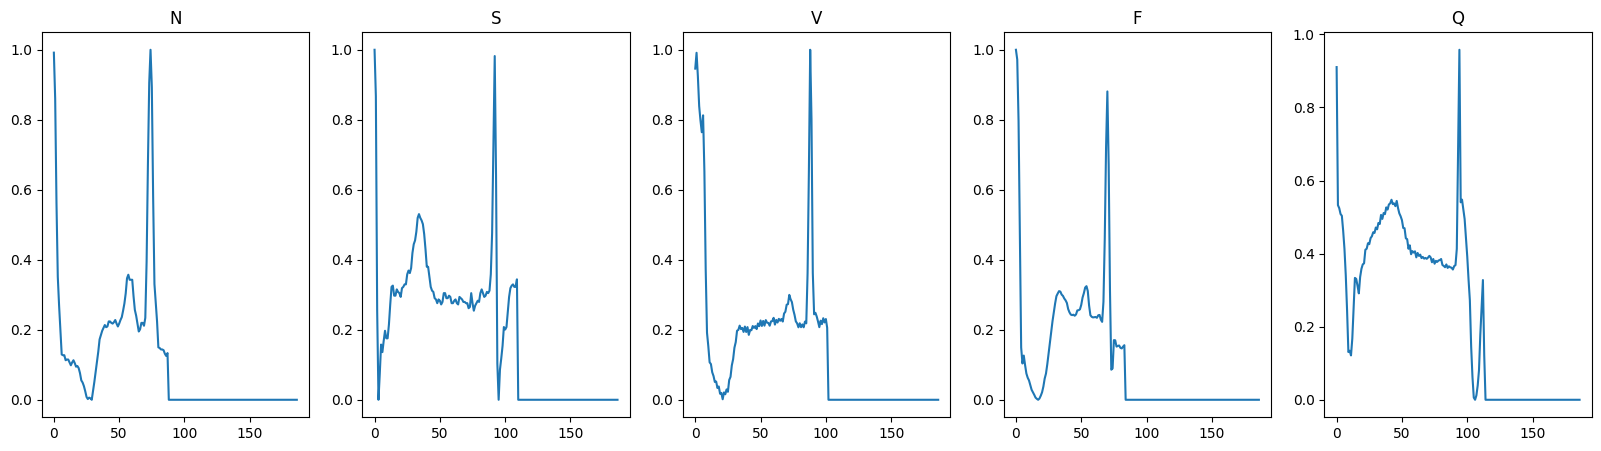

In [47]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)
raw_test_df = pd.read_csv("Data/mitbih_test.csv", header=None)

x_train = raw_train_df.iloc[:, :-1]
y_train = raw_train_df.iloc[:, -1]
x_test  = raw_test_df.iloc[:, :-1]
y_test  = raw_test_df.iloc[:, -1]

smote = SMOTE(sampling_strategy={1: 30000, 2: 20000, 3: 20000, 4: 10000}, random_state=0)
x_train, y_train = smote.fit_resample(x_train, y_train)

training_data = {
    "features": x_train,
    "labels"  : y_train,
}
test_data = {
    "features": x_test,
    "labels"  : y_test,
}

visualize_raw_ecg(training_data)

In [ ]:
transform_data("Data/mitbih_mif_train.h5", training_data, batch_size=5000)
transform_data("Data/mitbih_mif_test.h5", test_data, batch_size=5000)

In [18]:
raw_train_df = pd.read_csv("Data/mitbih_train.csv", header=None)

training_data = {
    "features": raw_train_df.iloc[60000:, :-1],
    "labels"  : raw_train_df.iloc[60000:, -1],
}

In [21]:
transform_data("Data/mitbih_mif_train_small.h5", training_data, batch_size=5000)

Transforming 27554 samples...


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 0-5000


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 5000-10000


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 10000-15000


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 15000-20000


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 20000-25000


C:\Users\Tavonput Luangphasy\AppData\Local\Temp\ipykernel_33244\2174971265.py:83: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


    Completed images 25000-27554
